<a href="https://colab.research.google.com/github/mnsosa/resistencia-de-materiales/blob/main/EyR_Parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estática y Resistencia de Materiales 

Se dividirán en secciones la práctica de distintos temas.

En algunos temas habrán cosas muy automatizadas, con declaraciones de clases más
completas. En otros, solo se escribirán las ecuaciones para se ahorre tiempo durante
el examen.

Se separarán los datos de los ejercicios en una dataclass con la resolución del ejercicio.

# Tracción y compresión

## Utilidades

Tensión
$$ \sigma = \frac{N}{\omega} $$ 
Deformación
$$ \delta _p = \frac{N*l}{\omega*E} $$
Alargamiento unitario
$$ \epsilon = \frac{\delta}{l} = \frac {\sigma}{E} $$
Dilatación térmica
$$ \delta _t = \alpha*L*\Delta T $$

Tensión generada por deformación con holgura δ_d
$$ \sigma = \delta _d \frac{E}{l} - \alpha E \Delta T $$

In [6]:
from numpy import pi, sqrt, array, dot, sum
from dataclasses import dataclass, field
from typing import Optional, List
import numpy as np

# RECORDAR REVISAR ESTO EN CADA EJERCICIO
# A veces redondean distinto las constantes

# CONSTANTES
E_ACERO = 2100000 # kg/cm2 
E_COBRE = 1.1*10**6 # kg/cm2
E_ALUMINIO = 703000 # kg/cm2
E_BRONCE = 1055000 # kg/cm2

ALFA_ACERO = 125 *10**(-7) # 1/°C
ALFA_ACERO_5 = 1*10**(-5) # 1/°C
ALFA_COBRE = 1.6*10**(-5) # 1/°C
ALFA_BRONCE = 20*10**(-6) # 1/°C
ALFA_ALUMINIO = 23*10**(-6) # 1/°C

SIGMA_ADM_ACERO = 1400 # kg/cm2


# Ecuaciones bases
def tension_normal(N, A): return N/A
def deformacion_p(N, L, A, E): return N*L/(A*E)
def deformacion_t(alfa, L, deltaT): return alfa*L*deltaT 
#------------------------------------------------------

@dataclass
class tracc_compresion:
  # Se inicializa con los datos del problema
  normal: float = None
  area: float = None
  largo: float = None
  tension: float = None

  deformacion: float = 0
  diam_externo: float = None
  diam_interno: float = None

  sigma_adm: float = None
  deformacion_adm: float = None
  E: float = None

  unidad_long: str = "cm"
  unidad_tension: str = "kg"

  # Para ejercicios con tramos
  largo_tramos: List[float] = field(default_factory=list)
  area_tramos: List[float] = field(default_factory=list)
  E_tramos: List[float] = field(default_factory=list)
  normal_tramos: List[float] = field(default_factory=list)


  def calcular_tension(self):
    normal = self.normal
    area = self.area

    tension = normal/area
    self.tension = tension
    print(f"La tensión es de {tension} {self.unidad_tension}/{self.unidad_long}^2")
    return tension

  def calcular_tension_por_tramos(self):
    normal_tramos = array(self.normal_tramos)
    areas = array(self.area_tramos)

    tensiones = normal_tramos / areas
    print(f"Las tensiones por tramos son: ")
    for i, t in enumerate(tensiones):
      print(f"Tramo {i} = {t}")

    return tensiones


  def calcular_esfuerzo_normal(self):
    self.normal = self.area*self.tension
    print(f"El esfuerzo normal es {self.normal} {self.unidad_tension}")


  def calcular_deformacion(self):
    normal = self.normal
    largo = self.largo
    area = self.area 
    E = self.E

    deformacion = (normal*largo)/(area*E)
    print(f"La deformación es de {deformacion} {self.unidad_long}")
    self.deformacion += deformacion
    return deformacion


  def calcular_deformacion_por_tramos(self):
    """Calcula desde abajo hacia arriba los tramos"""
    N = self.normal_tramos
    L = self.largo_tramos
    A = self.area_tramos
    E = self.E_tramos

    deformacion_total = 0
    for i in range(len(N)):
      print(f"Deformacion p en tramo {i+1}: {N[i]*L[i]/(A[i]*E[i])} {self.unidad_long}")
      deformacion_total += N[i]*L[i]/(A[i]*E[i])
    
    print("Deformación total =", deformacion_total)
    self.deformacion += deformacion_total
    return deformacion_total


  def calcular_diam_externo(self):
    diam_interno = self.diam_interno
    area = self.area

    diam_externo = sqrt(diam_interno**2 + area*4/pi)
    print(f"El diametro externo calculado es de {diam_externo} {self.unidad_long}")
    return diam_externo


  def calcular_diam_interno(self):
    diam_externo = self.diam_externo
    area = self.area

    diam_interno = sqrt(diam_externo**2 - area*4/pi)
    print(f"El diametro interno calculado es de {diam_interno} {self.unidad_long}")
    return diam_interno
  

  def calcular_area_por_diametros(self):
    """Si es macizo, poner diam_interno = 0"""
    diam_externo = self.diam_externo
    diam_interno = self.diam_interno

    area = pi/4*(diam_externo**2 - diam_interno**2)
    print(f"El area por los diametros es de {area} {self.unidad_long}^2")
    return area


  def calcular_area_por_tension_adm(self):
    """Dimensionar el área por tensión admisible"""
    sigma_adm = self.sigma_adm
    normal = self.normal

    area = normal/sigma_adm
    area_por_tension = area
    print(f"El area por dimensionamiento por tensión es de {area} {self.unidad_long}^2")
    return area


  def calcular_area_por_deformacion_adm(self):
    """Dimensionar por deformación admnisible"""
    normal = self.normal
    largo = self.largo
    deformacion_adm = self.deformacion_adm
    E = self.E

    area = normal*largo/(deformacion_adm*E)
    self.area_por_deformacion = area
    print(f"El area por dimensionamiento por deformación es de {area} {self.unidad_long}^2")
    return area


  def verificacion_area_por_tension(self):
    """Una vez calculada el area por deformacion, se checkea por tension"""
    sigma_adm = self.sigma_adm
    normal = self.normal
    area_def = self.area_por_deformacion

    verifica_por_tension = (normal/area_def <= sigma_adm)
    print(f"Verificación por tensión: {normal/area_def} <= {sigma_adm}")
    if not verifica_por_tension:
      print("No verifica tensión. Se debe redimensionar por tensión")
      self.area = self.calcular_area_por_tension_adm()
    else:
      print("Verifica por tensión.")
      self.area = self.area_por_deformacion


@dataclass
class efectos_termicos(tracc_compresion):
  """Tipo de problema de tracción compresión que incluye la dilatación térmica"""

  dilatacion: float = 0
  alfa: float = None
  deltaT: float = None


  def calcular_dilatacion_termica(self):
    self.dilatacion = self.alfa*self.deltaT*self.largo
    print(f"La dilatación térmica es de {self.dilatacion}")
    self.deformacion += self.dilatacion
    return self.dilatacion    
    

@dataclass
class piezas_con_holgura(efectos_termicos):
  """Tipo de problema donde se deja un espacio entre dos piezas que están por dilatarse"""
  holgura: float = None
  alfa_tramos: List[float] = field(default_factory=list)


  def calcular_tension_generada_por_dilatacion(self):
    # Si no estamos hablando de materiales distintos
    holgura = self.holgura
    E = self.E
    alfa = self.alfa
    deltaT = self.deltaT
    L = self.largo

    tension_generada = holgura*E/L - alfa*deltaT*E
    print(f"La tensión generada por la dilatación es de {tension_generada} {self.unidad_tension}")
    self.tension_generada = tension_generada
    self.tension = tension_generada
    
    # Cuando se tiene el área se puede calcular
    try:
      self.calcular_esfuerzo_normal() # También se calcula N
    except TypeError:
      print("Falta el área para calcular el esfuerzo normal")

    return tension_generada


  def calcular_normal_en_compresion(self): 
    holgura = self.holgura
    deltaT = self.deltaT
    alfas = array(self.alfa_tramos)
    largos = array(self.largo_tramos)
    E_vector = array(self.E_tramos)
    areas = array(self.area_tramos)

    N = (holgura - deltaT*dot(alfas, largos))/sum(largos/(E_vector*areas))
    print(f"En compresión tienen la misma N.\nN = {N}")
    self.normal_tramos = [N, N]
    return N


  def calcular_dilatacion_termica_por_tramos(self):
    holgura = self.holgura
    E = self.E_tramos
    alfa = self.alfa_tramos
    deltaT = self.deltaT
    L = self.largo_tramos

    dilatacion_total = 0
    for i in range(len(alfa)):
      print(f"Dilataciónn en tramo {i+1}: {deformacion_t(alfa[i], L[i], deltaT)} {self.unidad_long}")
      dilatacion_total += deformacion_t(alfa[i], L[i], deltaT)
    
    print("Dilatación total =", dilatacion_total)
    self.deformacion += dilatacion_total
    return dilatacion_total

  
  def calcular_salto_termico_para_que_se_toquen(self):
    """Calcula el salto térmico necesario para que dos piezas se toquen."""
    alfas = self.alfa_tramos
    E_vector = self.E_tramos
    areas = self.area_tramos
    L = self.largo_tramos
    dd = self.holgura

    deltaT = (dd - self.calcular_deformacion_por_tramos())/np.dot(alfas, L)
    print(f"El salto deltaT necesario es de {deltaT}")
    print(f"Con holgura de {dd}")
    return deltaT


class caldera:

  def __init__(self, p=None, r_area=None, e=None, N=None, A=None, E=None, 
               mu=0, abierto:bool=False, r_medio=None):
    self.r_area = r_area
    self.r_medio = r_medio
    self.e = e
    self.N = N
    self.E = E
    self.mu = mu
    self.abierto = abierto

    if not abierto and mu == 0:
      print(30*"-")
      print("FALTA PONER MU")
      print(30*"-", end="\n")

    if A == None:
      self.A = np.pi*r_area**2
    else:
      self.A = A

    if p == None:
      self.p = self.presion_hidrostatica()
    else:
      self.p = P

  # sigma circ
  def tension_circ(self):
    p = self.p
    r = self.r_medio
    e = self.e
    
    self.sigma_c = p*r/e
    print(f"Tensión circ = {self.sigma_c}")
    return self.sigma_c

  # sigma long
  # Si está abierto entonces no hay sigma long
  def tension_long(self):
    if self.abierto:
      self.sigma_l = 0
      return 0
    
    self.sigma_l = self.sigma_c/2
    print(f"Tensión long = {self.sigma_l}")
    return self.sigma_l

  # Ley de Hooke bidimensional
  def hooke_circ(self):
    E = self.E
    mu = self.mu
    sigma_c = self.sigma_c
    sigma_l = self.sigma_l

    print(f"Hook circ = {1/E * (sigma_c - mu*sigma_l)}")
    return 1/E * (sigma_c - mu*sigma_l) 

  def hooke_long(self):
    E = self.E
    print(f"Hooke long = {1/E*(self.sigma_l - self.mu*self.sigma_c)}")
    return (1/E*(self.sigma_l - self.mu*self.sigma_c))

  def presion_hidrostatica(self):
    print(f"Presión hidroestática = {self.N/self.A}")
    return self.N/self.A

  def variacion_diametro(self):
    print(f"La variación del diámetro es de {self.hooke_circ()*self.r_medio*2}")
    return self.hooke_circ()*self.r_medio*2

## Guía 5-1: Tensiones y deformaciones

### Ejercicio 5-1

Determinar el diámetro interno φi que debe tener la sección recta anular de una
pieza de acero poco esbelta, sometida a compresión por una carga axial de 12t, siendo
σ_adm=1400 kg/cm2 y φ_e=5cm

In [5]:
# Datos en kg y cm
ej_5_1 = tracc_compresion(normal=12000, sigma_adm=1400, diam_externo=5, E=E_ACERO)
print(ej_5_1)
print("\n")

# Resolución
ej_5_1.area = ej_5_1.calcular_area_por_tension_adm()

ej_5_1.calcular_diam_interno();

tracc_compresion(normal=12000, area=None, largo=None, tension=None, deformacion=0, diam_externo=5, diam_interno=None, sigma_adm=1400, deformacion_adm=None, E=2100000, unidad_long='cm', unidad_tension='kg', largo_tramos=[], area_tramos=[], E_tramos=[], normal_tramos=[])


El area por dimensionamiento por tensión es de 8.571428571428571 cm^2
El diametro interno calculado es de 3.7532010588275604 cm


### Ejercicio 5-2

Un tensor de acero de 1,30m de longitud, debe soportar una carga de 4,6t.

Determinar el alargamiento total y las dimensiones de su sección recta, siendo ésta:

a) - circular

b) - cuadrada

c) - rectangular con h = 2b

σadm = 2400kg/cm2 

E = 2100000kg/cm2

In [6]:
# Datos
ej_5_2 = tracc_compresion(sigma_adm=2400, E=E_ACERO, normal=4600, largo=130)
print(ej_5_2)
print("\n")

# Resolucion
ej_5_2.area = ej_5_2.calcular_area_por_tension_adm()
ej_5_2.diam_interno = 0
ej_5_2.calcular_diam_externo()
ej_5_2.calcular_deformacion();

tracc_compresion(normal=4600, area=None, largo=130, tension=None, deformacion=0, diam_externo=None, diam_interno=None, sigma_adm=2400, deformacion_adm=None, E=2100000, unidad_long='cm', unidad_tension='kg', largo_tramos=[], area_tramos=[], E_tramos=[], normal_tramos=[])


El area por dimensionamiento por tensión es de 1.9166666666666667 cm^2
El diametro externo calculado es de 1.5621702193025344 cm
La deformación es de 0.14857142857142858 cm


### Ejercicio 5-3

Una barra de acero de sección circular de 2,20m de longitud, está sometida a
una carga de tracción de 12t. Siendo el máximo alargamiento permitido δ=0,16cm, determinar
el diámetro de la barra. 

Datos

σadm=1400 kg/cm2 

E=2100000 kg/cm2

In [8]:
# Datos
ej_5_3 = tracc_compresion(largo=220, normal=12000, deformacion_adm=0.16, E=E_ACERO, sigma_adm=1400)
print(ej_5_3, "\n\n")

# Resolución
ej_5_3.calcular_area_por_deformacion_adm()
ej_5_3.verificacion_area_por_tension()
ej_5_3.diam_interno = 0 # Es macizo 
ej_5_3.calcular_diam_externo();

tracc_compresion(normal=12000, area=None, largo=220, tension=None, deformacion=0, diam_externo=None, diam_interno=None, sigma_adm=1400, deformacion_adm=0.16, E=2100000, unidad_long='cm', unidad_tension='kg', largo_tramos=[], area_tramos=[], E_tramos=[], normal_tramos=[]) 


El area por dimensionamiento por deformación es de 7.857142857142857 cm^2
Verificación por tensión: 1527.2727272727273 <= 1400
No verifica tensión. Se debe redimensionar por tensión
El area por dimensionamiento por tensión es de 8.571428571428571 cm^2
El diametro externo calculado es de 3.3035559344463477 cm


### Ejercicio 5-4

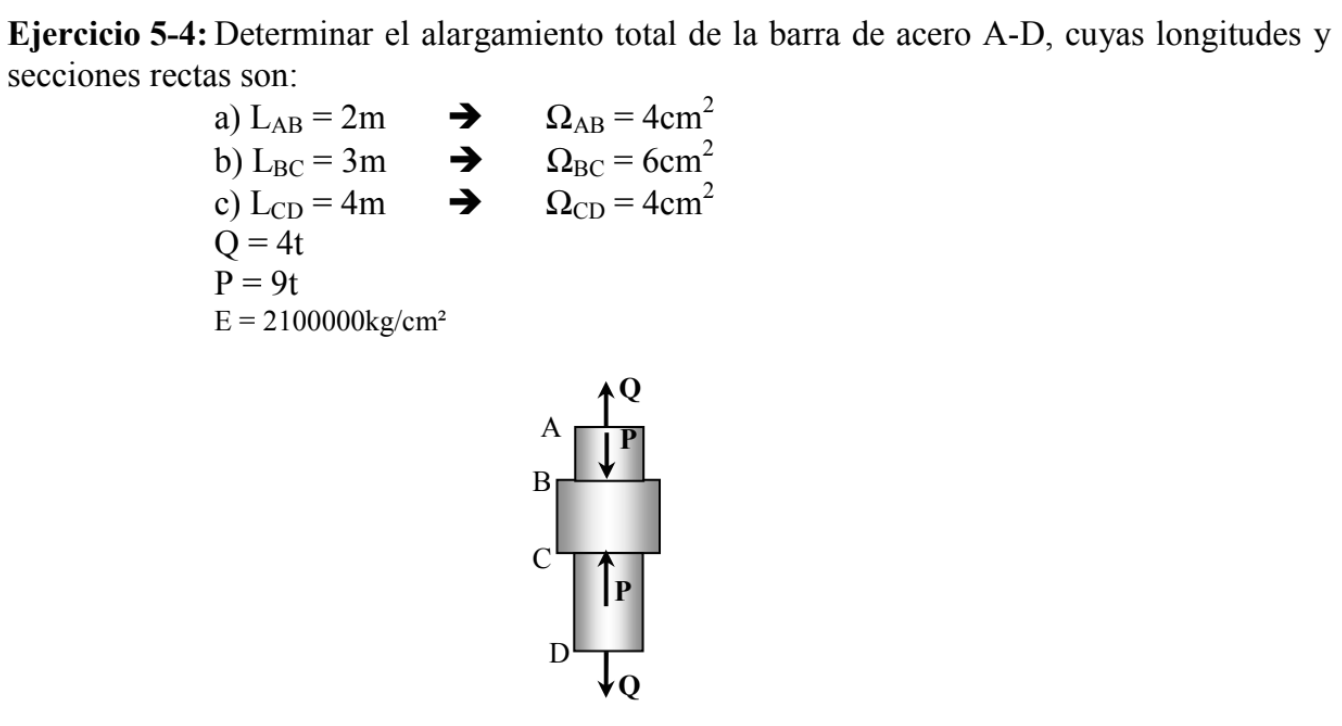

In [9]:
# Datos
ej_5_4 = tracc_compresion(normal_tramos=[9000, 5000, 9000], 
                          area_tramos=[4, 6, 4],
                          largo_tramos=[200, 300, 400],
                          E_tramos=[E_ACERO, E_ACERO, E_ACERO])

print(ej_5_4, "\n\n")

# Resolución
ej_5_4.calcular_deformacion_por_tramos();

tracc_compresion(normal=None, area=None, largo=None, tension=None, deformacion=0, diam_externo=None, diam_interno=None, sigma_adm=None, deformacion_adm=None, E=None, unidad_long='cm', unidad_tension='kg', largo_tramos=[200, 300, 400], area_tramos=[4, 6, 4], E_tramos=[2100000, 2100000, 2100000], normal_tramos=[9000, 5000, 9000]) 


Deformacion p en tramo 1: 0.21428571428571427 cm
Deformacion p en tramo 2: 0.11904761904761904 cm
Deformacion p en tramo 3: 0.42857142857142855 cm
Deformación total = 0.7619047619047619


## Guía 5-2: Efectos térmicos

### Ejercicio 5-6

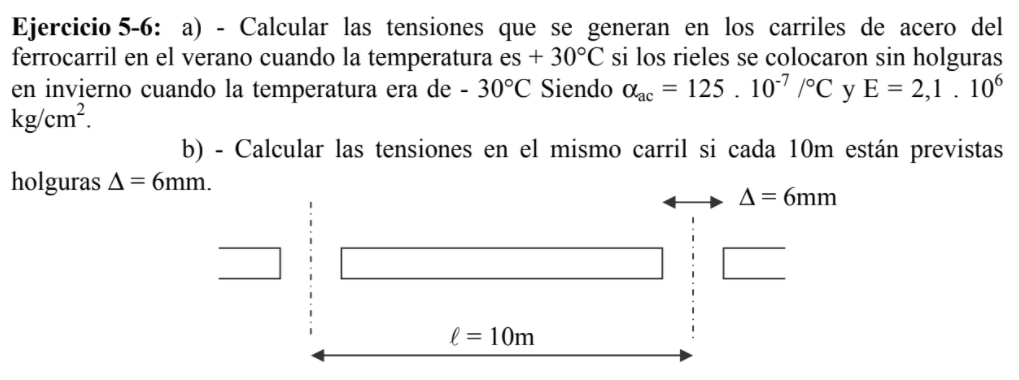

In [24]:
# Datos
ej_5_6 = piezas_con_holgura(deltaT=60, holgura=0, alfa=ALFA_ACERO, E=E_ACERO, largo=1000)

# Resolucion
ej_5_6.calcular_tension_generada_por_dilatacion()

# Segunda parte, con holgura = 0.6
ej_5_6.holgura = 0.6

# Resolución
ej_5_6.calcular_tension_generada_por_dilatacion()
ej_5_6.calcular_dilatacion_termica();

La tensión generada por la dilatación es de -1574.9999999999998 kg
Falta el área para calcular el esfuerzo normal
La tensión generada por la dilatación es de -314.9999999999998 kg
Falta el área para calcular el esfuerzo normal
La dilatación térmica es de 0.7499999999999999


### Ejercicio 5-7

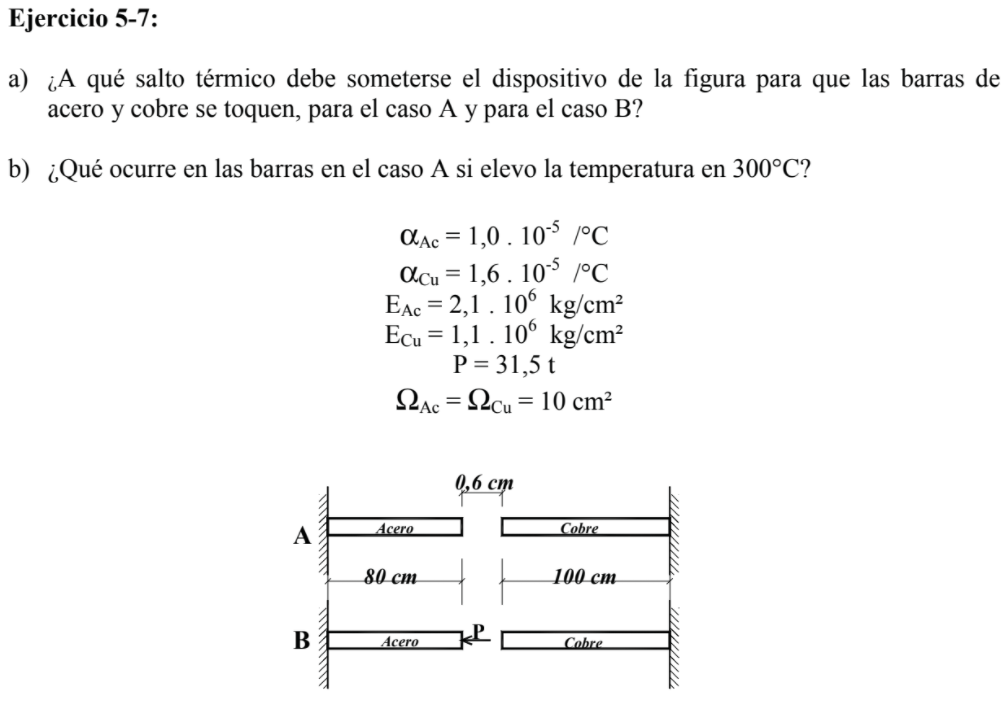

In [14]:
# Datos
"""
  NOTAR QUE EN ESTE EJERCICIO SE APROXIMA DISTINTO EL ALFA ACERO
  Por lo que se ingresa directamente el valor de 1.0 *10^-5
"""
ej_5_7 = piezas_con_holgura(holgura=0.6, 
                            largo_tramos=[80, 100],
                            alfa_tramos=[1.0*10**(-5), ALFA_COBRE], 
                            E_tramos=[E_ACERO, E_COBRE], 
                            area_tramos=[10, 10])
print(ej_5_7, "\n\n")

# Resolución
print("Caso A")
ej_5_7.calcular_salto_termico_para_que_se_toquen()

# Caso b
print("\nCaso B")
ej_5_7.normal_tramos = [-31500, 0]
ej_5_7.calcular_salto_termico_para_que_se_toquen();

# Parte 2 del ejercicio
# Se eleva la temperatura a 300 C para el caso A (sin P)
print("\nParte 2")
ej_5_7.deltaT = 300
ej_5_7.normal_tramos = [0, 0]
print("\n")
ej_5_7.calcular_normal_en_compresion()
ej_5_7.calcular_tension_por_tramos();

piezas_con_holgura(normal=None, area=None, largo=None, tension=None, deformacion=0, diam_externo=None, diam_interno=None, sigma_adm=None, deformacion_adm=None, E=None, unidad_long='cm', unidad_tension='kg', largo_tramos=[80, 100], area_tramos=[10, 10], E_tramos=[2100000, 1100000.0], normal_tramos=[], dilatacion=0, alfa=None, deltaT=None, holgura=0.6, alfa_tramos=[1e-05, 1.6000000000000003e-05]) 


Caso A
Deformación total = 0
El salto deltaT necesario es de 249.99999999999997
Con holgura de 0.6

Caso B
Deformacion p en tramo 1: -0.12 cm
Deformacion p en tramo 2: 0.0 cm
Deformación total = -0.12
El salto deltaT necesario es de 299.99999999999994
Con holgura de 0.6

Parte 2


En compresión tienen la misma N.
N = -9302.013422818802
Las tensiones por tramos son: 
Tramo 0 = -930.2013422818802
Tramo 1 = -930.2013422818802


### Ejercicio 5-8

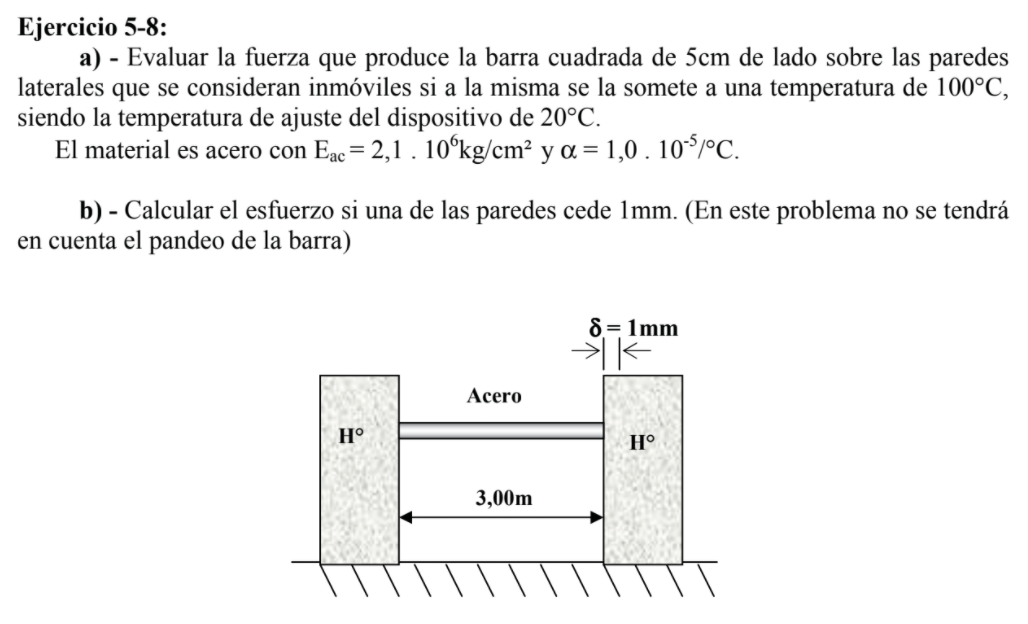

In [17]:
# Datos
ej_5_8 = piezas_con_holgura(holgura=0,
                            E=E_ACERO,
                            alfa=ALFA_ACERO_5,
                            deltaT=80,
                            area=5*5, 
                            largo=300)
# Resolución
# Parte 1
print("Parte 1. Sin holgura")
ej_5_8.calcular_tension_generada_por_dilatacion()
ej_5_8.calcular_esfuerzo_normal()

# Parte 2
print("\nParte 2. Con holgura 0.1 cm")
ej_5_8.holgura = 0.1 
ej_5_8.calcular_tension_generada_por_dilatacion();
ej_5_8.calcular_esfuerzo_normal();

Parte 1. Sin holgura
La tensión generada por la dilatación es de -1680.0 kg
El esfuerzo normal es -42000.0 kg

Parte 2. Con holgura 0.1 cm
La tensión generada por la dilatación es de -980.0 kg
El esfuerzo normal es -24500.0 kg


### Ejercicio de parcial - 1


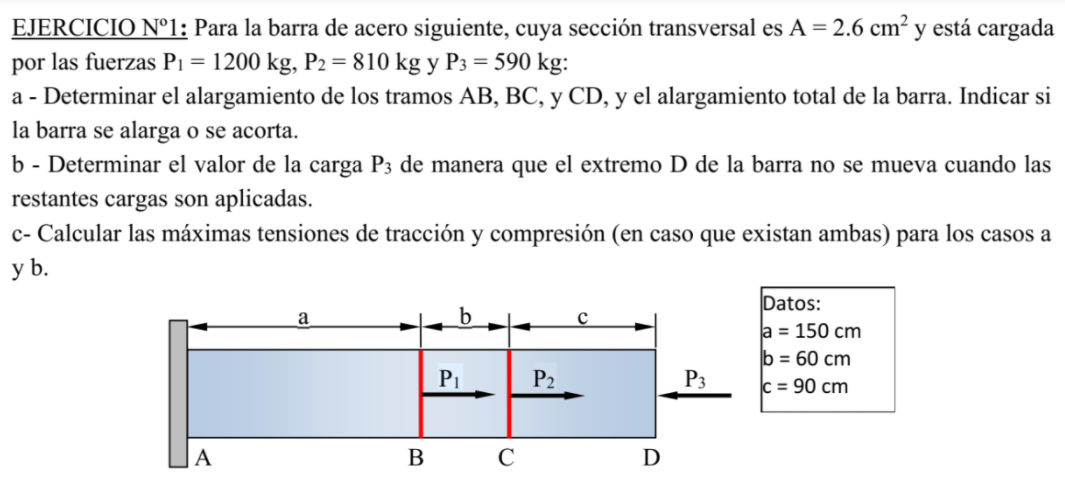

In [18]:
#-----------------------------------------------------------
# REVISAR LAS NORMALES. LAS P NO SON LAS NORMALES POR TRAMO! 
#-----------------------------------------------------------

# Datos
ej_parcial_alargamiento_1 = piezas_con_holgura(area_tramos=[2.6, 2.6, 2.6], 
                                             normal_tramos=[1420, 220, -590],
                                             largo_tramos=[150, 60, 90],
                                             E_tramos=[E_ACERO, E_ACERO, E_ACERO])
print(ej_parcial_alargamiento_1)

# Resolución
print("\nParte a")
ej_parcial_alargamiento_1.calcular_deformacion_por_tramos();

print("\nParte b")

piezas_con_holgura(normal=None, area=None, largo=None, tension=None, deformacion=0, diam_externo=None, diam_interno=None, sigma_adm=None, deformacion_adm=None, E=None, unidad_long='cm', unidad_tension='kg', largo_tramos=[150, 60, 90], area_tramos=[2.6, 2.6, 2.6], E_tramos=[2100000, 2100000, 2100000], normal_tramos=[1420, 220, -590], dilatacion=0, alfa=None, deltaT=None, holgura=None, alfa_tramos=[])

Parte a
Deformacion p en tramo 1: 0.03901098901098901 cm
Deformacion p en tramo 2: 0.0024175824175824176 cm
Deformacion p en tramo 3: -0.009725274725274725 cm
Deformación total = 0.031703296703296704

Parte b


### Ejercicio de parcial - 2


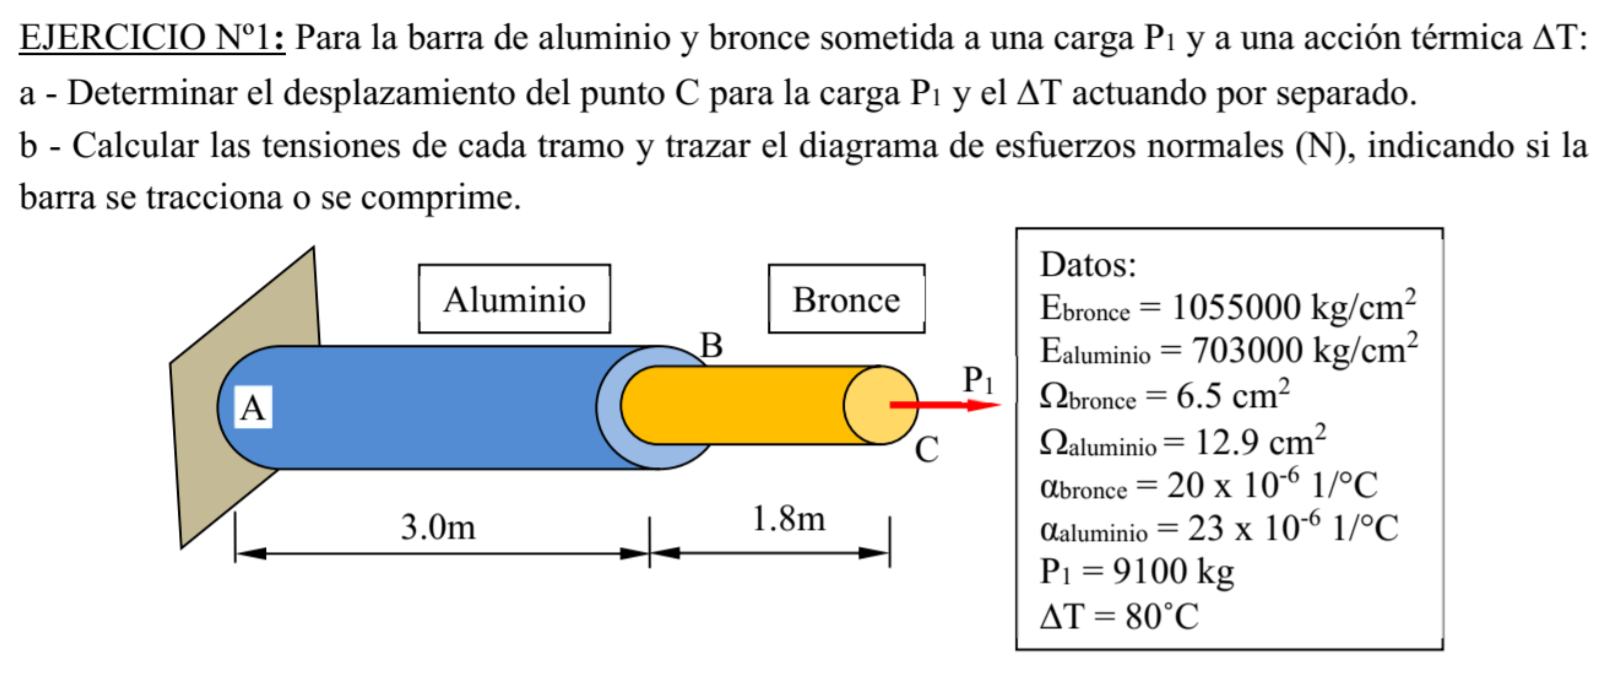

In [19]:
# Datos
ej_parcial_alargamiento_2 = piezas_con_holgura(E_tramos=[E_ALUMINIO, E_BRONCE], 
                                             area_tramos=[12.9, 6.5],
                                             alfa_tramos=[ALFA_ALUMINIO, ALFA_BRONCE],
                                             normal_tramos=[9100, 9100], 
                                             deltaT=80,
                                             largo_tramos=[300, 180])
print(ej_parcial_alargamiento_2)
# Resolución
print("\nParte a")
ej_parcial_alargamiento_2.calcular_dilatacion_termica_por_tramos();
print("\nDeformacion por P")
ej_parcial_alargamiento_2.calcular_deformacion_por_tramos();

print("\nParte b")
ej_parcial_alargamiento_2.calcular_tension_por_tramos();

piezas_con_holgura(normal=None, area=None, largo=None, tension=None, deformacion=0, diam_externo=None, diam_interno=None, sigma_adm=None, deformacion_adm=None, E=None, unidad_long='cm', unidad_tension='kg', largo_tramos=[300, 180], area_tramos=[12.9, 6.5], E_tramos=[703000, 1055000], normal_tramos=[9100, 9100], dilatacion=0, alfa=None, deltaT=80, holgura=None, alfa_tramos=[2.3e-05, 1.9999999999999998e-05])

Parte a
Dilataciónn en tramo 1: 0.552 cm
Dilataciónn en tramo 2: 0.288 cm
Dilatación total = 0.8400000000000001

Deformacion por P
Deformacion p en tramo 1: 0.3010354295544014 cm
Deformacion p en tramo 2: 0.23886255924170616 cm
Deformación total = 0.5398979887961075

Parte b
Las tensiones por tramos son: 
Tramo 0 = 705.4263565891473
Tramo 1 = 1400.0


## Guía 5-3: Caldera

### Ejercicio 5-13

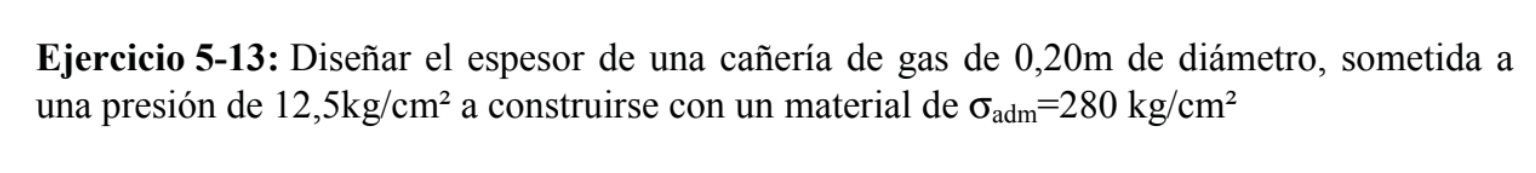

In [ ]:
# Datos
 

# Estado plano de tensiones

## Utilidades

In [7]:
import matplotlib.pyplot as plt
from numpy import pi
import numpy as np

# --------------- MOHR ------------------
class Mohr:
  """Calcula los valores claves del círculo de Mohr y otras funcionalidades"""
  
  sigma_alfa = None
  sigma_alfa_90 = None

  def __init__(self, sigmax, sigmay, taux):
    self.sigmax = sigmax
    self.sigmay = sigmay
    self.taux = taux

    self.centro = (self.sigmax + self.sigmay)/2
    self.R = np.sqrt(((self.sigmax-self.sigmay)/2)**2 + self.taux**2)
    self.tensiones_principales = (self.centro + self.R, self.centro - self.R)
    try: 
      beta_aux = np.rad2deg(np.arctan(self.taux/(self.sigmax-self.centro)))/2
    except ZeroDivisionError:
      beta_aux = 45

    self.beta_aux = beta_aux
    
    # si el signo de beta no coincide con la direccion de taux, debe corregirse
    if np.sign(beta_aux) != np.sign(self.taux):
      # si beta es positivo, se corrige a negativo
      if np.sign(beta_aux) == 1: 
        self.beta = beta_aux - 90
      else:
      # beta es negativo pero taux positivo, se corrige a positivo
        self.beta = beta_aux + 90
    else: 
      # los signos coinciden
      self.beta = beta_aux
    

  def dibujar(self):
    theta = np.linspace(0, 2*np.pi, 100)
    r = self.R
    x1 = r*np.cos(theta) 
    x2 = r*np.sin(theta)

    fig, ax = plt.subplots(1, figsize=(8,8))
    # circulo
    ax.plot(x1 + self.centro, x2)
    
    # puntos adicionales
    punto0 = self.centro, 0
    punto1 = self.sigmax, self.taux
    punto2 = self.centro, self.R
    punto3 = self.sigmay, -self.taux
    punto4 = self.tensiones_principales[0], 0
    punto5 = self.tensiones_principales[1], 0

    puntos = [punto0, punto1, punto2, punto3, punto4, punto5]
    text_puntos = ["centro", "(sx, txy)", "tmax", "(sy, txy)", "s1", "s2"]

    # graficar y poner textos
    for p, t in zip(puntos, text_puntos):
      ax.plot(p[0], p[1], 'yo')
      plt.annotate(t,xy=p,
                 arrowprops=dict(arrowstyle='->'),
                 xytext=(p[0] + self.R*0.10, p[1] + self.R*0.10))
    # Notar que la distancia de los textos son proporcionales a R

    
    xlim_derecha = self.centro + self.R*1.3
    xlim_izquierda = self.centro - self.R*1.3

    plt.xlim([xlim_izquierda, xlim_derecha])
    plt.ylim([-self.R*1.33, self.R*1.33])
    plt.xlabel('sigma')
    plt.ylabel('tau')
    ax.set_aspect(1)
    plt.grid(linestyle='--')
    plt.title('CÍRCULO DE MOHR', fontsize=20)
    plt.show()


  def calcular_sigma_tau_alfa(self, alfa):
    # Se convierte alfa en radianes
    a = np.deg2rad(alfa)
    a_90 = np.deg2rad(alfa+90)
    sx = self.sigmax
    sy = self.sigmay
    tx = self.taux

    sigma_alfa_funcion = lambda a: (sx + sy)/2 + (sx - sy)/2*np.cos(2*a) + tx*np.sin(2*a)

    print(f"sigma({alfa}°) = ({sx} + {sy})/2 + ({sx} - {sy})/2 * cos(2*{alfa}) + {tx}sin(2*{alfa})")

    self.sigma_alfa = sigma_alfa_funcion(a)
    self.sigma_alfa_90 = sigma_alfa_funcion(a_90)
                                            
    self.tau_alfa = -(sx - sy)/2*np.sin(2*a) + tx*np.cos(2*a)

    print("El sigma alfa es", self.sigma_alfa)
    print("El sigma alfa + 90 es", self.sigma_alfa_90)
    print("El tau alfa es", self.tau_alfa)
    print("\nComprobación... ")
    print("sigma_alfa + sigma_alfa_90 = sigmax + sigma")
    print(f"{self.sigma_alfa + self.sigma_alfa_90} = {self.sigmax + self.sigmay}")

  

  def resultados(self):
    print("El centro (normal donde corte es máximo) es", self.centro)
    print("El radio (corte máximo) es", self.R)
    print("Las tensiones principales son (sig1, sig2) =", self.tensiones_principales)
    print("El beta es", self.beta, "grados")
    if self.sigma_alfa != None: 
      print("\nSigma alfa es", self.sigma_alfa)
      print("Sigma alfa + 90 es", self.sigma_alfa_90)

    print("El ángulo donde tau se hace máximo, y sigmas iguales, es de",
          self.calcular_alfa_tau_max())

  
  def calcular_alfa_tau_max(self):
    if abs(self.beta) < 45:
      return self.beta + np.sign(self.beta)*45
    else:
      return (self.beta - np.sign(self.beta)*45)

## Ejercicio parcial 2 recuperatorio

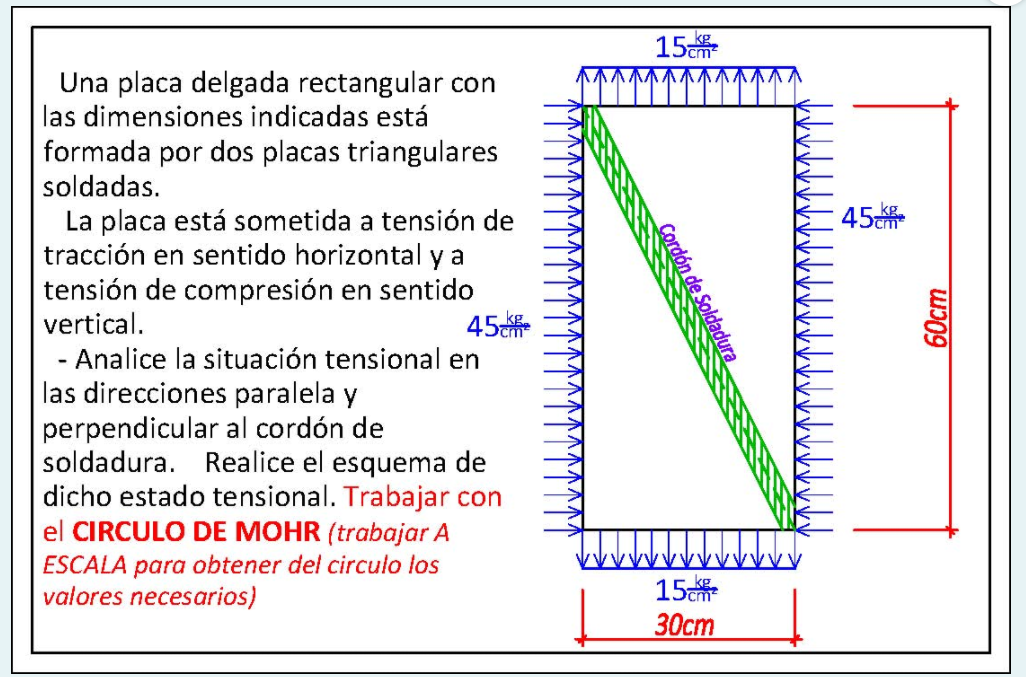

El centro (normal donde corte es máximo) es 30.0
El radio (corte máximo) es 15.0
Las tensiones principales son (sig1, sig2) = (45.0, 15.0)
El beta es 0.0 grados
El ángulo donde tau se hace máximo, y sigmas iguales, es de 0.0
sigma(63.43°) = (45 + 15)/2 + (45 - 15)/2 * cos(2*63.43) + 0sin(2*63.43)
El sigma alfa es 21.00207309237389
El sigma alfa + 90 es 38.99792690762611
El tau alfa es -12.001554539517702

Comprobación... 
sigma_alfa + sigma_alfa_90 = sigmax + sigma
60.0 = 60


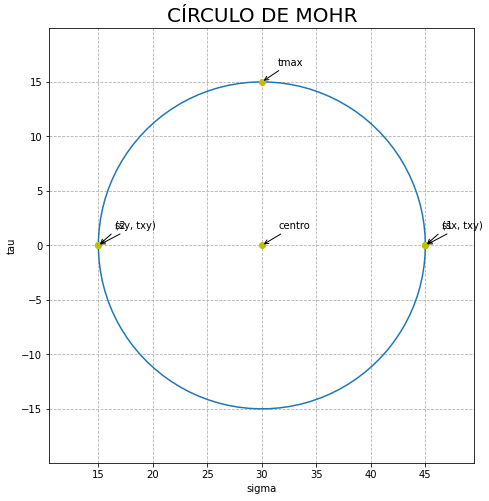

In [9]:
parcial_ej1 = Mohr(sigmax=45, sigmay=15, taux=0)
parcial_ej1.resultados()
parcial_ej1.calcular_sigma_tau_alfa(63.43)
parcial_ej1.dibujar()

## Guía 6: Estado plano de tensiones

### Ejercicio 6-1

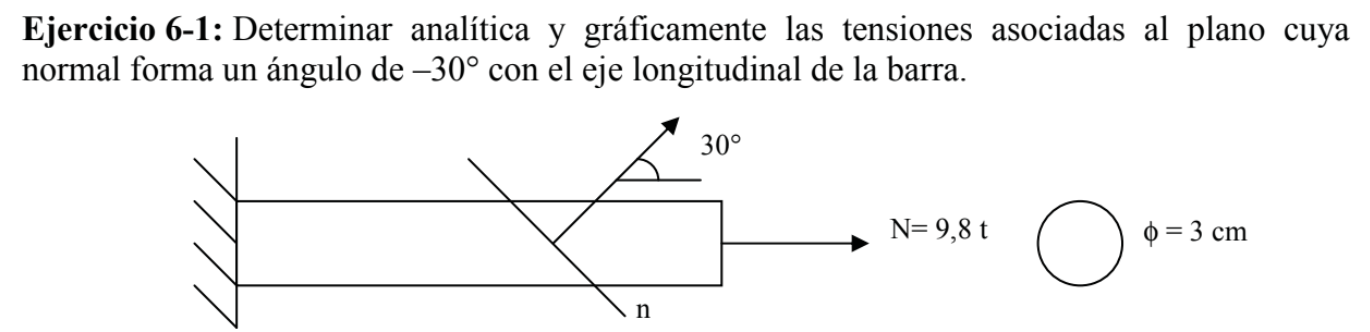

El sigma X es 1386.416393156066
El centro (normal donde corte es máximo) es 693.208196578033
El radio (corte máximo) es 693.208196578033
Las tensiones principales son (sig1, sig2) = (1386.416393156066, 0.0)
El beta es 0.0 grados


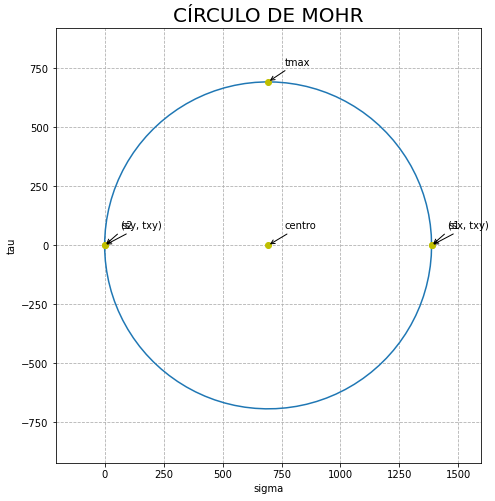

El sigma alfa es 1039.8122948670496
El sigma alfa + 90 es 346.6040982890167
El tau alfa es 600.3359083481736

Comprobación... 
1386.4163931560663 = 1386.416393156066


In [ ]:
# Datos
ej_6_1 = Mohr(sigmax=(9800/(pi/4*3**2)), sigmay=0, taux=0)

# Resolución
print("El sigma X es", ej_6_1.sigmax)
ej_6_1.resultados()
ej_6_1.dibujar()

ej_6_1.calcular_sigma_tau_alfa(-30)

### Ejercicio 6-2


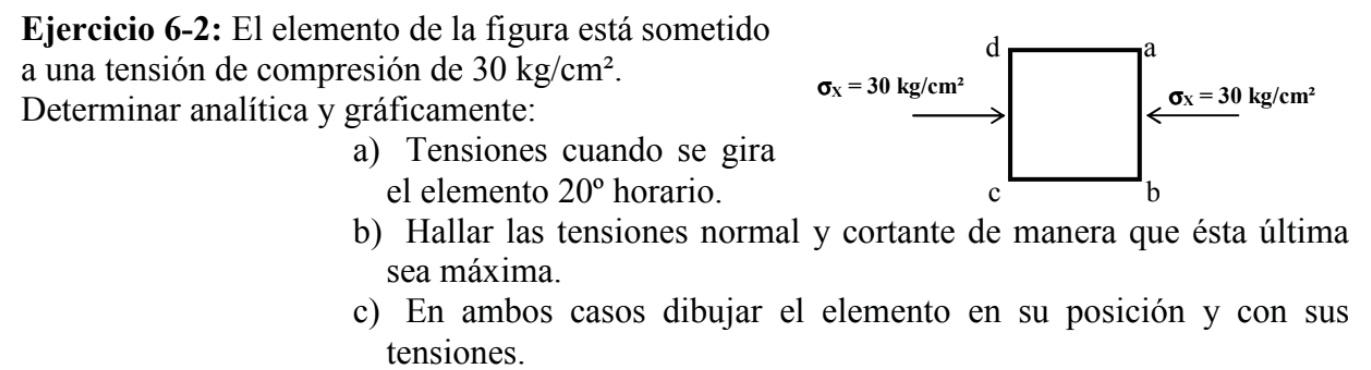

Parte a)
sigma(20°) = (-30 + 0)/2 + (-30 - 0)/2 * cos(2*20) + 0sin(2*20)
El sigma alfa es -26.490666646784668
El sigma alfa + 90 es -3.5093333532153306
El tau alfa es 9.641814145298088

Comprobación... 
sigma_alfa + sigma_alfa_90 = sigmax + sigma
-30.0 = -30


Parte b)
El centro (normal donde corte es máximo) es -15.0
El radio (corte máximo) es 15.0
Las tensiones principales son (sig1, sig2) = (0.0, -30.0)
El beta es -0.0 grados

Sigma alfa es -26.490666646784668
Sigma alfa + 90 es -3.5093333532153306


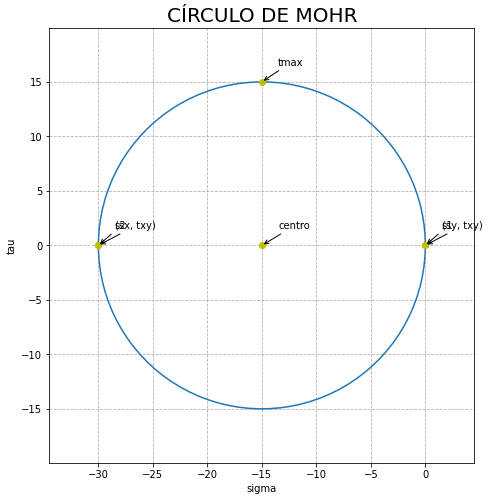

In [ ]:
# Datos
ej_6_2 = Mohr(sigmax=-30, sigmay=0, taux=0)

# Resolución
print("Parte a)")
ej_6_2.calcular_sigma_tau_alfa(20)

print("\n\nParte b)")
ej_6_2.resultados()

ej_6_2.dibujar()

### Ejercicio 6-7

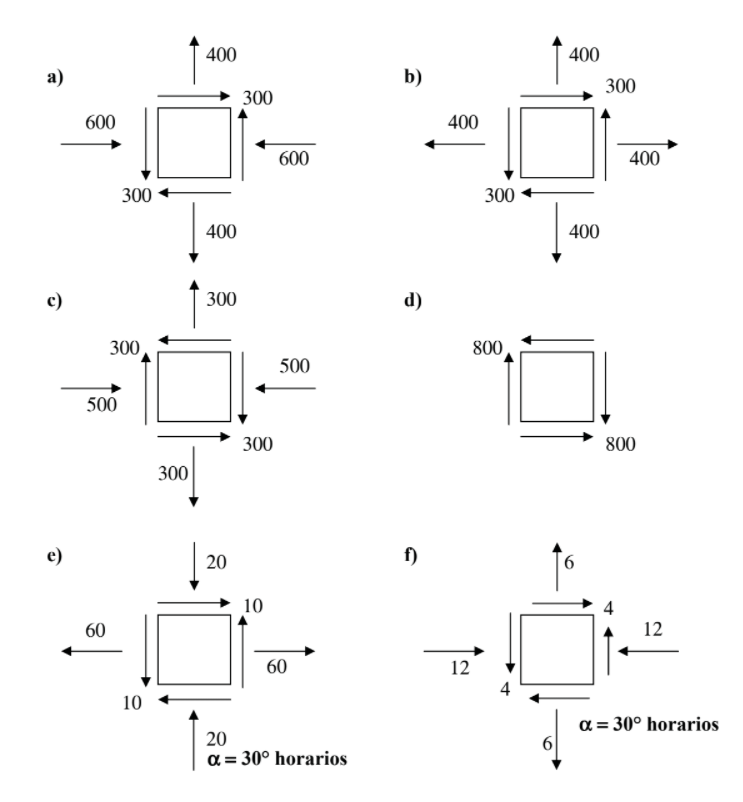

#### Ejercicio 6-7 a)

El centro (normal donde corte es máximo) es -100.0
El radio (corte máximo) es 583.09518948453
Las tensiones principales son (sig1, sig2) = (483.09518948453, -683.09518948453)
El beta es -74.51812173396324 grados
El ángulo donde tau se hace máximo, y sigmas iguales, es de -29.51812173396324


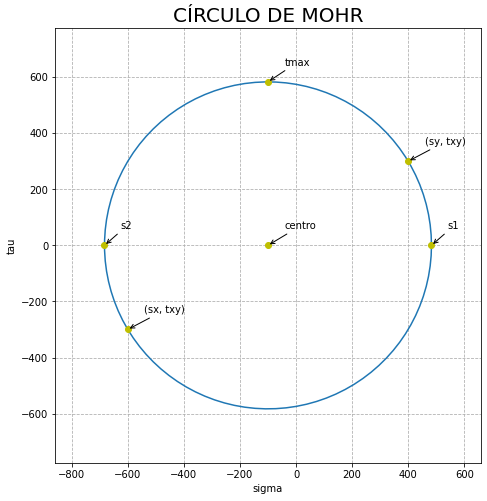

In [ ]:
# a)
ej_6_7_a = Mohr(sigmax=-600, sigmay=400, taux=-300)
ej_6_7_a.resultados()
ej_6_7_a.dibujar()

#### Ejercicio 6-7 b)

El centro (normal donde corte es máximo) es 400.0
El radio (corte máximo) es 300.0
Las tensiones principales son (sig1, sig2) = (700.0, 100.0)
El beta es -45 grados
El ángulo donde tau se hace máximo, y sigmas iguales, es de 0


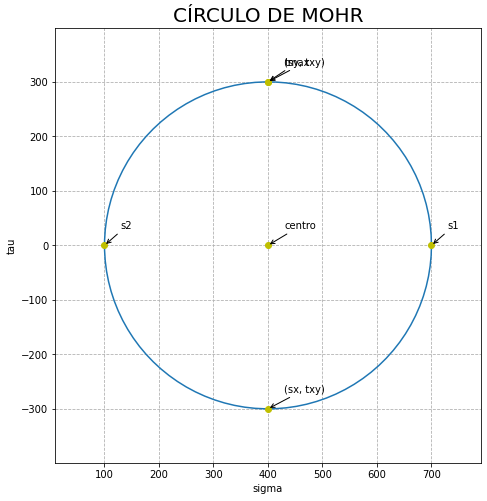

In [ ]:
# b)
ej_6_7_b = Mohr(400, 400, -300)
ej_6_7_b.resultados()
ej_6_7_b.dibujar()

#### Ejercicio 6-7 c)

El centro (normal donde corte es máximo) es -100.0
El radio (corte máximo) es 500.0
Las tensiones principales son (sig1, sig2) = (400.0, -600.0)
El beta es 71.56505117707799 grados
El ángulo donde tau se hace máximo, y sigmas iguales, es de 26.56505117707799


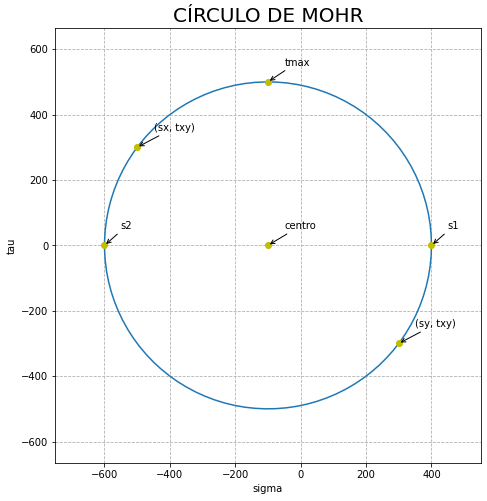

In [ ]:
# c)
ej_6_7_c = Mohr(-500, 300, 300)
ej_6_7_c.resultados()
ej_6_7_c.dibujar()

#### Ejercicio 6-7 d)

El centro (normal donde corte es máximo) es 0.0
El radio (corte máximo) es 800.0
Las tensiones principales son (sig1, sig2) = (800.0, -800.0)
El beta es 45 grados
El ángulo donde tau se hace máximo, y sigmas iguales, es de 0


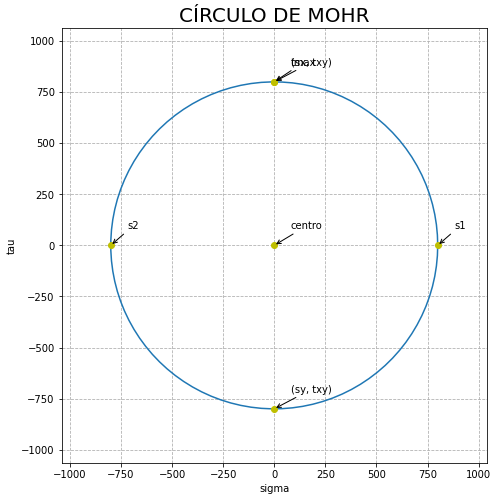

In [ ]:
# d)
ej_6_7_d = Mohr(0, 0, 800)
ej_6_7_d.resultados()
ej_6_7_d.dibujar()

#### Ejercicio 6-7 e)

El centro (normal donde corte es máximo) es 20.0
El radio (corte máximo) es 41.23105625617661
Las tensiones principales son (sig1, sig2) = (61.23105625617661, -21.231056256176608)
El beta es -7.018121733963239 grados
El ángulo donde tau se hace máximo, y sigmas iguales, es de -52.01812173396324


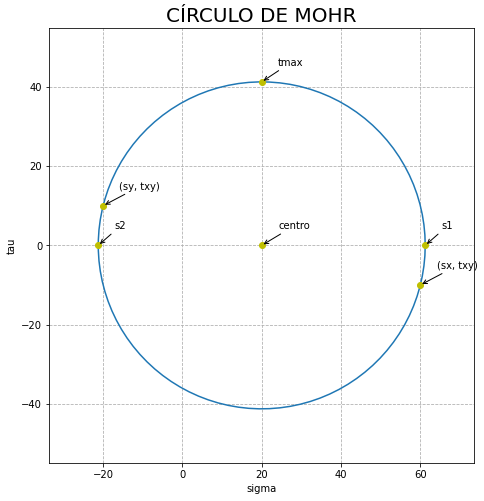

sigma(30°) = (60 + -20)/2 + (60 - -20)/2 * cos(2*30) + -10sin(2*30)
El sigma alfa es 31.339745962155614
El sigma alfa + 90 es 8.660254037844366
El tau alfa es -39.64101615137754

Comprobación... 
sigma_alfa + sigma_alfa_90 = sigmax + sigma
39.99999999999998 = 40


In [ ]:
# e)
ej_6_7_e = Mohr(60, -20, -10)
ej_6_7_e.resultados()
ej_6_7_e.dibujar()
ej_6_7_e.calcular_sigma_tau_alfa(30)

#### Ejercicio 6-7 f)

El centro (normal donde corte es máximo) es -3.0
El radio (corte máximo) es 9.848857801796104
Las tensiones principales son (sig1, sig2) = (6.848857801796104, -12.848857801796104)
El beta es -78.01875551271091 grados
El ángulo donde tau se hace máximo, y sigmas iguales, es de -33.01875551271091


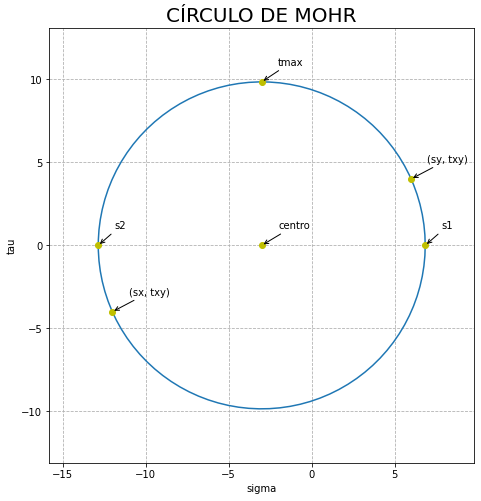

sigma(30°) = (-12 + 6)/2 + (-12 - 6)/2 * cos(2*30) + -4sin(2*30)
El sigma alfa es -10.964101615137755
El sigma alfa + 90 es 4.964101615137757
El tau alfa es 5.794228634059946

Comprobación... 
sigma_alfa + sigma_alfa_90 = sigmax + sigma
-5.999999999999998 = -6


In [ ]:
# f)
ej_6_7_f = Mohr(-12, 6, -4)
ej_6_7_f.resultados()
ej_6_7_f.dibujar()
ej_6_7_f.calcular_sigma_tau_alfa(30)

# Propiedades de Inercia de las Superficies Planas

## Utilidades

$$ \sum I = I_i $$

$$ I_i = \frac{bh^3}{12} + b_ih_id_i^2 $$

$$ d_i = {CG}_i - Y_{CG} $$ 

In [3]:
from dataclasses import dataclass, field
from numpy import array, dot
import numpy as np

@dataclass
class Inercia:
  y_cg: float = None
  # Distancias desde los centros al eje Z en Y_CG
  distancias: List[float] = field(default_factory=list)
  bases:      List[float] = field(default_factory=list)
  alturas:    List[float] = field(default_factory=list)
  centros:    List[float] = field(default_factory=list)

  unidad_long: str = "cm"
  unidad_fuerza: str = "kg"


  def calcular_Y_cg(self):
    b = array(self.bases)
    a = array(self.alturas)
    CG = array(self.centros)

    self.y_cg = dot(a, CG)/sum(a)
    print("El centro YCG es", self.y_cg, self.unidad_long)
    return self.y_cg


  def calcular_centros(self):
    """ SOLO USAR SI LA FIGURA ES DE CIERTA FORMA """
    a = self.alturas
    a_ant = 0
    for i in range(len(a)):
      self.centros.append(a[i]/2 + a_ant)
      a_ant += a[i]

    print("Los centros son", self.centros, self.unidad_long)

  
  def calcular_distancias(self):
    d = array(self.centros) - self.y_cg
    self.distancias = list(d)
    print("Las distancias al YCG es", self.distancias, self.unidad_long)


  def calcular_inercia(self):
    bases = array(self.bases)
    alturas = array(self.alturas)
    distancias = array(self.distancias)

    inercias = bases*alturas**3/12 + bases*alturas*distancias**2
    self.inercias = inercias
    self.I = sum(inercias)
    print("Las inercias por tramo son:", inercias, self.unidad_long, "^4")
    print("La inercia total es de", self.I, self.unidad_long, "^4")
    return self.I 


  def calcular_todo_desde_base_altura_forma_bien(self):
    self.calcular_centros()
    self.calcular_Y_cg()
    self.calcular_distancias()
    self.calcular_inercia()

## Guía 7: inercia de superficies planas

### Ejercicio 7-1

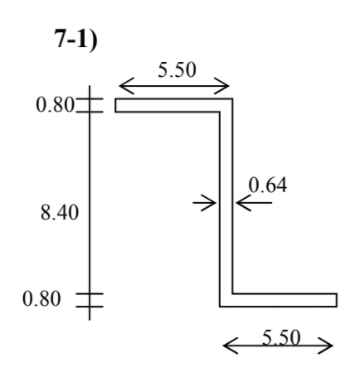

In [ ]:
# Datos
ej_7_1 = Inercia(
            y_cg=5, 
            distancias=[5-0.4, 0, 5-0.4],
            alturas=[0.8, 8.4, 0.8],
            bases=[5.5, 0.64, 5.5]
            )
print("Datos")
print(ej_7_1, "\n\n")

# Resolución
ej_7_1.calcular_inercia();

# Haciendo un cambio de ejes 
print("\nParte 2")
ej_7_1 = Inercia(
            y_cg=5.18, 
            distancias=[-2.75, 0, 2.75],
            alturas=[4.86, 0.64, 4.86],
            bases=[0.8, 0.64, 0.8]
            )
print(ej_7_1, "\n\n")

ej_7_1.calcular_inercia();

Datos
Inercia(y_cg=5, distancias=[4.6, 0, 4.6], bases=[5.5, 0.64, 5.5], alturas=[0.8, 8.4, 0.8], centros=[], unidad_long='cm', unidad_fuerza='kg') 


Las inercias por tramo son: [93.33866667 31.61088    93.33866667] cm ^4
La inercia total es de 218.28821333333335 cm ^4

Parte 2
Inercia(y_cg=5.18, distancias=[-2.75, 0, 2.75], bases=[0.8, 0.64, 0.8], alturas=[4.86, 0.64, 4.86], centros=[], unidad_long='cm', unidad_fuerza='kg') 


Las inercias por tramo son: [3.70557504e+01 1.39810133e-02 3.70557504e+01] cm ^4
La inercia total es de 74.12548181333335 cm ^4


In [ ]:
# Mismo ejercicio anterior pero probando calcular las distancias
ej_7_1 = Inercia(
    bases=[5.5, 0.64, 5.5],
    alturas=[0.8, 8.4, 0.8]
)

ej_7_1.calcular_centros()
ej_7_1.calcular_Y_cg()
ej_7_1.calcular_distancias()
ej_7_1.calcular_inercia();

Los centros son [0.4, 5.0, 9.600000000000001] cm
El centro YCG es 4.999999999999999 cm
Las distancias al YCG es [-4.599999999999999, 8.881784197001252e-16, 4.600000000000002] cm
Las inercias por tramo son: [93.33866667 31.61088    93.33866667] cm ^4
La inercia total es de 218.2882133333334 cm ^4


In [ ]:
# Mismo ejercicio anterior pero probando HACER TODO DESDE BASE ALTURA
ej_7_1 = Inercia(
    bases=[5.5, 0.64, 5.5],
    alturas=[0.8, 8.4, 0.8]
)

ej_7_1.calcular_todo_desde_base_altura_forma_bien()

Los centros son [0.4, 5.0, 9.600000000000001] cm
El centro YCG es 4.999999999999999 cm
Las distancias al YCG es [-4.599999999999999, 8.881784197001252e-16, 4.600000000000002] cm
Las inercias por tramo son: [93.33866667 31.61088    93.33866667] cm ^4
La inercia total es de 218.2882133333334 cm ^4


### Ejercicio parcial 2


In [ ]:
p2_ej = Inercia(bases=[15, 2, 5],
                alturas=[2, 18, 2])

p2_ej.calcular_todo_desde_base_altura_forma_bien()


In [20]:
p2 = Inercia(
    y_cg = 8.37,

    bases=[15, 2, 5],  
    alturas=[2, 18, 2],
            )

p2.calcular_centros()
p2.calcular_distancias()
p2.calcular_inercia()
p2.calcular_

Los centros son [1.0, 11.0, 21.0] cm
Las distancias al YCG es [-7.369999999999999, 2.630000000000001, 12.63] cm
Las inercias por tramo son: [1639.507      1221.0084     1598.50233333] cm ^4
La inercia total es de 4459.017733333333 cm ^4


4459.017733333333

# Flexión pura plana

## Utilidades

$$ \sigma = \frac{My}{I} $$ 

$$ \frac{1}{\rho} = \frac{M}{EI} $$

$$ \epsilon = \frac{y}{\rho} = \frac{\sigma}{E} $$

Se dimensiona utilizando W, y se busca ese W en tabla.

Se calcula el W y se busca el W inmediatamente siguiente en tabla.
$$ W_{nec} =  \frac{M_{max}}{\sigma _{adm}} $$

$$ W_z > W_{nec} $$

Luego, con el W elegido, se calcula el sigma máximo

$$ \sigma _{max} = \frac{M_{max}}{W_z} $$

In [23]:
@dataclass
class flexion_pura(Inercia):
  E: float = None # Para deformación
  sigma_normal: float = None # Tensión normal
  sigma_normal_max: float = None # Tensión normal máxima
  M_max: float = None # El momento maximo
  sigma_adm: float = None # La tensión admisible
  W_z_elegido: float = None # El Wz con el que se dimensiona


  def calcular_sigma_normal(self, y, M):
    """
    'y' es la altura a la que queremos saber el sigma normal
    'm' es el momento flector en punto que queremos calcular
    """
    I = self.I
    self.sigma_normal = M*y/I
    print(f"La tensión normal en {y} es de {self.sigma_normal} {self.unidad_fuerza}/{self.unidad_long}^2")
    return self.sigma_normal


  def calcular_W_nec_dimensionar(self):
    M = self.M_max
    sigma_adm = self.sigma_adm
    print(f"El W necesario es de al menos {M/sigma_adm} {self.unidad_long}^3")
    return M/sigma_adm


  def calcular_sigma_normal_maxima(self):
    self.sigma_normal_max = self.M_max/self.W_z_elegido
    print(f"La tensión normal máxima es {self.sigma_normal_max} {self.unidad_fuerza}/{self.unidad_long}^2")
    return self.sigma_normal_max

In [25]:
p2 = flexion_pura(
    y_cg = 8.37,

    bases=[15, 2, 5],  
    alturas=[2, 18, 2],
            )

p2.calcular_centros()
p2.calcular_distancias()
p2.calcular_inercia()
p2.calcular_sigma_normal(13.63, 162440)
p2.I

Los centros son [1.0, 11.0, 21.0] cm
Las distancias al YCG es [-7.369999999999999, 2.630000000000001, 12.63] cm
Las inercias por tramo son: [1639.507      1221.0084     1598.50233333] cm ^4
La inercia total es de 4459.017733333333 cm ^4
La tensión normal en 13.63 es de 496.5347375608853 kg/cm^2


4459.017733333333

## Guía 8

### Ejercicio 8-1

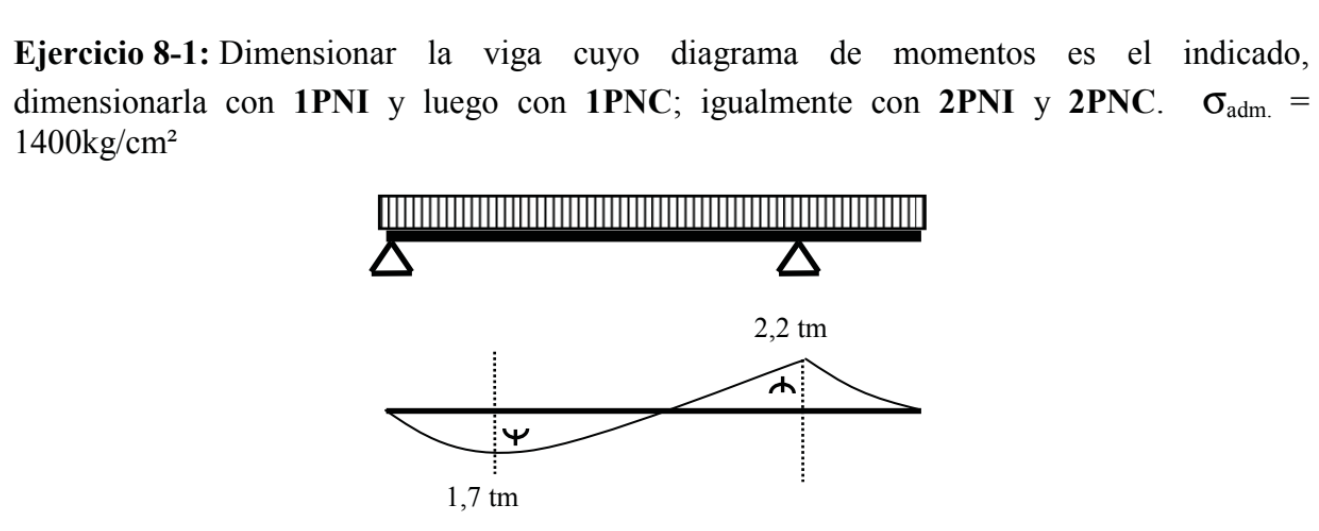

In [31]:
ej_8_1 = flexion_pura(M_max=220000, sigma_adm=SIGMA_ADM_ACERO)

ej_8_1.calcular_W_nec_dimensionar()

# Se elige el PNI 18 con Wz = 161 cm3
ej_8_1.W_z_elegido = 161
ej_8_1.calcular_sigma_normal_maxima();

# Si se utiliza un PNI 20 de Wz = 191 cm3
ej_8_1.W_z_elegido = 191
ej_8_1.calcular_sigma_normal_maxima();

El W necesario es de al menos 157.14285714285714 cm^3
La tensión normal máxima es 1366.4596273291925 kg/cm^2
La tensión normal máxima es 1151.8324607329844 kg/cm^2


# Torsión

## Utilidades

## Guía 9-1

## Guía 9-2

## Guía 9-3

# Corte en vigas flexionadas

## Utilidades


$$ \sigma = \frac{M_f * y}{I} $$

$$ \tau = \frac{T*S_n}{E*I} $$


In [5]:
from dataclasses import dataclass
from numpy import pi, dot, array
import numpy as np

@dataclass
class corte_en_flexion(flexion_pura):
  corte: float = None

  def calcular_corte(self):
    T = self.T_max
    Sn = self.Sn
    e = self.e
    I = self.I

    self.corte = T*Sn/(e*I)
    print(f"El corte es de {self.corte} {self.unidad_fuerza}/{self.unidad_long}^2")
    return self.corte

## Guía 10-1

## Guía 10-2

# Deformación de las vigas rectas en flexión plata

## Utilidades

## Guía 11-1

## Guía 11-2